## Part 1 Demo

### Import Libraries

In [7]:
import torch # type: ignore
import cv2 # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from ultralytics import YOLO # type: ignore
from PIL import Image # type: ignore

### Load the YOLOv8 nano model

In [8]:
model = YOLO('yolov8n.pt') 

### Perform Object Detection on image

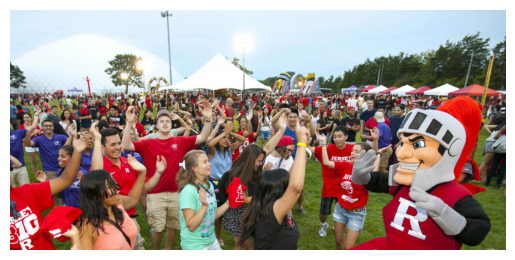

In [9]:
img = Image.open('rutgers_yolo_demo.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
results = model(img)[0]
results.show()

print(f" Number of objects detected: {len(results.boxes)}")


0: 320x640 11 persons, 2 umbrellas, 56.2ms
Speed: 6.3ms preprocess, 56.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
 Number of objects detected: 13


Analyze each box: \
    * xyxy – the coordinates of the box as an array [x1,y1,x2,y2] \
    * cls – the ID of object type\
    * conf – the confidence level of the model about this object. If it's very low, like < 0.5, then you can just ignore the box.

In [17]:
for i in range(len(results.boxes)):
    box = results.boxes[i]
    print(f"Box {i+1}")
    print("Object type:", box.cls)
    print("Coordinates:", box.xyxy)
    print("Probability:", box.conf)

Box 1
Object type: tensor([0.])
Coordinates: tensor([[   0.0000,  478.6086,  360.7437, 1017.1666]])
Probability: tensor([0.8444])
Box 2
Object type: tensor([0.])
Coordinates: tensor([[ 473.6917,  423.0759,  903.6674, 1022.6761]])
Probability: tensor([0.8129])
Box 3
Object type: tensor([0.])
Coordinates: tensor([[1437.7606,  409.9444, 2050.8237, 1013.4162]])
Probability: tensor([0.7758])
Box 4
Object type: tensor([0.])
Coordinates: tensor([[ 711.1332,  595.2645,  896.6069, 1019.3846]])
Probability: tensor([0.7246])
Box 5
Object type: tensor([0.])
Coordinates: tensor([[ 978.8608,  418.4179, 1286.0315, 1017.9715]])
Probability: tensor([0.6417])
Box 6
Object type: tensor([0.])
Coordinates: tensor([[1286.9309,  488.7567, 1547.3315, 1011.9902]])
Probability: tensor([0.5994])
Box 7
Object type: tensor([0.])
Coordinates: tensor([[ 868.7534,  566.7349, 1096.1786, 1014.6988]])
Probability: tensor([0.5758])
Box 8
Object type: tensor([0.])
Coordinates: tensor([[335.0403, 492.3843, 586.5386, 975.56

### Real-time Object Detection on Video

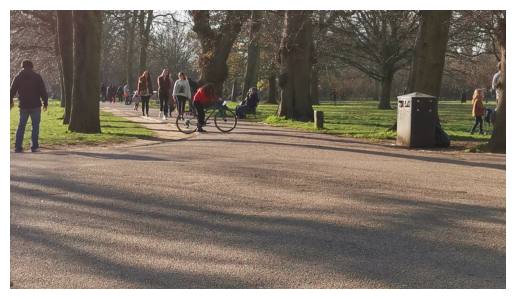

In [18]:
video_path = "yolo_demo_video.mp4"  
cap = cv2.VideoCapture(video_path)

# Read the first frame and display it
ret, frame = cap.read()
if ret:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
cap.release()

In [19]:
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the output video writer
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends
    
    # Run YOLOv8 inference on the frame
    results = model(frame)

    # Draw detections on the frame
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            conf = box.conf[0]  # Confidence score
            cls = int(box.cls[0])  # Class index
            label = f"{model.names[cls]} {conf:.2f}"
            
            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out.write(frame)  # Save frame to video

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 10 persons, 1 bicycle, 99.0ms
Speed: 23.3ms preprocess, 99.0ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 1 dog, 56.1ms
Speed: 2.4ms preprocess, 56.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 53.1ms
Speed: 2.1ms preprocess, 53.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 44.1ms
Speed: 2.2ms preprocess, 44.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 57.9ms
Speed: 2.3ms preprocess, 57.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 53.6ms
Speed: 1.5ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 48.7ms
Speed: 2.0ms preprocess, 48.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1

## Part 2 Demo

### Import more libraries

In [10]:
from filterpy.kalman import KalmanFilter # type: ignore
from scipy.optimize import linear_sum_assignment # type: ignore
from scipy.spatial.distance import cosine # type: ignore
from skimage.feature import hog # type: ignore
import time 

### Backend Code

#### Helper Functions

In [ ]:
def extract_features(frame, bbox):
    """
    Extract appearance features from a detected person to help with tracking.
    
    Args:
        frame: Input video frame
        bbox: Bounding box coordinates [x1, y1, x2, y2]
    
    Returns:
        Combined feature vector of color and HOG features
    
    Key Concepts:
    - Color features: Uses HSV color histogram which is more robust to lighting changes
    - HOG features: Captures shape/edge information that helps distinguish different people
    - Feature combination: Merges both types for more robust tracking
    """
    x1, y1, x2, y2 = map(int, bbox[:4])
    person_image = frame[y1:y2, x1:x2]
    
    # Standardize image size for consistent feature extraction
    person_image = cv2.resize(person_image, (64, 128))
    
    # Color histogram in HSV space (more robust to lighting changes)
    hsv_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [8, 8], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    color_features = hist.flatten()
    
    # HOG features for shape/edge information
    gray_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), 
                      cells_per_block=(2, 2), visualize=False)
    
    return np.concatenate([color_features, hog_features])

In [25]:
def iou(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        bbox1, bbox2: Bounding box coordinates [x1, y1, x2, y2]
    
    Returns:
        IoU score between 0 and 1
    
    Note: IoU is a key metric for measuring spatial overlap between detections
    and predicted track locations.
    """
    # Calculate intersection coordinates
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    # Calculate areas
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

In [26]:
def compute_similarity(feature1, feature2, bbox1, bbox2, time_diff):
    """
    Compute overall similarity between two detections using multiple cues.
    
    Args:
        feature1, feature2: Appearance feature vectors
        bbox1, bbox2: Bounding box coordinates
        time_diff: Time difference between detections in frames
    
    Returns:
        Weighted similarity score combining appearance, spatial, and temporal information
    
    Note: You can adjust the weights (0.7, 0.2, 0.1) to change the importance of each factor
    """
    appearance_sim = 1 - cosine(feature1, feature2)  # Feature similarity
    spatial_sim = iou(bbox1, bbox2)                  # Spatial overlap
    temporal_weight = np.exp(-time_diff / 30)        # Temporal decay
    
    # Weighted combination - adjust these weights based on your needs
    return appearance_sim * 0.7 + spatial_sim * 0.2 + temporal_weight * 0.1


In [28]:
def generate_color(idx):
    """
    Generate consistent colors for visualization based on track ID.
    
    Args:
        idx: Track ID number
    
    Returns:
        RGB color tuple
    
    Note: Same track ID will always get the same color
    """
    np.random.seed(idx)
    color = tuple(map(int, np.random.randint(0, 255, 3)))
    return color

#### Kalman Filter

This class represents the internal state of individual tracked objects using Kalman filter.

Key Features:
- Maintains position and velocity estimates
- Tracks confidence and feature history
- Handles track initialization and updates

Important Parameters:
- max_feature_history: Number of past features to store (default: 10)
- reid_confidence: Track reliability score (0.0 to 1.0)

In [ ]:
class KalmanBoxTracker:
    count = 0  # Class variable for unique ID generation
    
    def __init__(self, bbox):
        """Initialize tracker with bounding box detection."""
        # Initialize Kalman filter with 7 state variables and 4 measurement variables
        # State: [x, y, w, h, dx, dy, dw] (position, size, velocity)
        # Measurement: [x, y, w, h] (position and size)
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        
        # Set up transition matrix (how state evolves)
        self.kf.F = np.array([[1,0,0,0,1,0,0],  # x = x + dx
                             [0,1,0,0,0,1,0],    # y = y + dy
                             [0,0,1,0,0,0,1],    # w = w + dw
                             [0,0,0,1,0,0,0],    # h = h
                             [0,0,0,0,1,0,0],    # dx = dx
                             [0,0,0,0,0,1,0],    # dy = dy
                             [0,0,0,0,0,0,1]])   # dw = dw

        # Measurement matrix (what we can measure)
        self.kf.H = np.array([[1,0,0,0,0,0,0],  # We can measure x
                             [0,1,0,0,0,0,0],    # We can measure y
                             [0,0,1,0,0,0,0],    # We can measure w
                             [0,0,0,1,0,0,0]])   # We can measure h

        # Tune these parameters based on your needs:
        self.kf.R[2:,2:] *= 10.    # Measurement noise
        self.kf.P[4:,4:] *= 1000.  # Initial state uncertainty
        self.kf.P *= 10.           # Initial state uncertainty
        self.kf.Q[-1,-1] *= 0.01   # Process noise
        self.kf.Q[4:,4:] *= 0.01   # Process noise

        # Initialize state with first detection
        self.kf.x[:4] = bbox[:4].reshape(4,1)
        
        # Track metadata
        self.time_since_update = 0
        self.id = self.get_next_id()
        self.history = []
        self.hits = 0                    # Number of detections
        self.hit_streak = 0              # Consecutive detections
        self.age = 0                     # Total frames
        self.reid_confidence = 0.5       # Track confidence score
        self.feature_history = []        # Store appearance features
        self.max_feature_history = 10    # Maximum features to store
        self.last_position = bbox[:4]    # Last known position
        self.last_seen_frame = 0         # Frame number when last seen

    @classmethod
    def get_next_id(cls):
        """Generate unique track IDs."""
        id = cls.count
        cls.count += 1
        return id

    def update_features(self, feature):
        """Update appearance feature history."""
        self.feature_history.append(feature)
        if len(self.feature_history) > self.max_feature_history:
            self.feature_history.pop(0)

    def get_average_feature(self):
        """Get average appearance feature from history."""
        if not self.feature_history:
            return None
        return np.mean(self.feature_history, axis=0)

    def update(self, bbox, frame_count=None):
        """
        Update tracker state with new detection.
        
        Args:
            bbox: New detection bounding box
            frame_count: Current frame number (optional)
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(bbox[:4].reshape(4,1))
        self.reid_confidence = min(1.0, self.reid_confidence + 0.1)
        self.last_position = bbox[:4]
        if frame_count is not None:
            self.last_seen_frame = frame_count

    def predict(self):
        """
        Advance tracker state and return predicted bounding box estimate.
        
        Returns:
            Predicted bounding box location
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(self.kf.x)
        self.reid_confidence = max(0.0, self.reid_confidence - 0.05)
        return self.history[-1]

    def get_state(self):
        """Return current bounding box estimate."""
        return self.kf.x[:4].flatten()

#### OC-SORT

OC-SORT implementation optimized for dynamic videos.

Key Features:
- Robust tracking during rapid movements
- Identity recovery after occlusions
- Appearance feature matching

Customization Points:
- Adjust weights between appearance, position, and motion
- Tune thresholds for different movement patterns
- Modify temporal windows for different video types

In [27]:
class OCSort:    
    def __init__(self, 
                 det_thresh=0.3,        # Detection confidence threshold
                 max_age=45,            # Maximum frames to keep dead tracks
                 min_hits=2,            # Minimum hits to initialize track
                 iou_threshold=0.2,     # IOU threshold for matching
                 max_history=50,        # Maximum frames of history
                 id_cooldown=90,        # Frames before ID can be reused
                 delta_t=2,             # Time window for prediction
                 appearance_weight=0.55, # Weight for appearance matching
                 position_weight=0.15,   # Weight for spatial matching
                 motion_weight=0.30):    # Weight for motion prediction
        """
        Initialize tracker with customizable parameters.
        
        Tip: Adjust these parameters based on your video characteristics:
        - For faster movements: decrease iou_threshold, increase motion_weight
        - For more pose changes: decrease appearance_weight
        - For longer occlusions: increase max_age, id_cooldown
        """
        # Core tracking parameters
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.det_thresh = det_thresh
        self.max_history = max_history
        self.id_cooldown = id_cooldown
        self.delta_t = delta_t
        
        # Matching weights
        self.appearance_weight = appearance_weight
        self.position_weight = position_weight
        self.motion_weight = motion_weight
        
        # Track management
        self.trackers = []
        self.frame_count = 0
        self.lost_trackers = []
        self.recent_detections = []
        self.inactive_trackers = {}
        self.id_feature_history = {}
        
        # Exercise-specific parameters
        self.temporal_window = 45       # Frames to look back for recovery
        self.vertical_motion_threshold = 1.5  # For jumping movements
        self.size_change_threshold = 0.4      # For pose changes
        
        # Recovery thresholds
        self.recovery_similarity_threshold = 0.55
        self.reid_threshold = 0.6

        # Exercise-specific parameters
        self.vertical_motion_threshold = 1.5  # Allow for jumping motion
        self.size_change_threshold = 0.4      # Allow for pose changes

    def update(self, dets, features=None):
        self.frame_count += 1
        
        if len(dets) == 0:
            return np.empty((0, 6))

        # Clean up old inactive trackers
        self._cleanup_inactive_trackers()

        trks = np.zeros((len(self.trackers), 5))
        to_del = []
        for t, trk in enumerate(self.trackers):
            pos = trk.predict()
            if np.any(np.isnan(pos)):
                to_del.append(t)
            else:
                if pos.ndim == 2 and pos.shape[1] == 1:
                    pos = pos[:, 0]
                if len(pos) >= 4:
                    trks[t, :4] = pos[:4]
                    trks[t, 4] = trk.time_since_update
                else:
                    print(f"Warning: unexpected pos shape: {pos.shape}")
                    to_del.append(t)

        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
            self._deactivate_tracker(self.trackers[t])
            self.trackers.pop(t)

        matched, unmatched_dets, unmatched_trks = self.associate_detections_to_trackers(dets, trks, features)

        # Update matched trackers with assigned detections
        for m in matched:
            self.trackers[m[1]].update(dets[m[0], :], self.frame_count)
            if features is not None and m[0] < len(features):
                self.trackers[m[1]].update_features(features[m[0]])
                self._update_id_features(self.trackers[m[1]].id, features[m[0]])

        # Create and initialise new trackers for unmatched detections
        for i in unmatched_dets:
            trk = KalmanBoxTracker(dets[i,:])
            if features is not None and i < len(features):
                trk.update_features(features[i])
                self._update_id_features(trk.id, features[i])
            self.trackers.append(trk)

        # Store current detections
        if len(dets) > 0:
            self.recent_detections.append({
                'frame': self.frame_count,
                'detections': dets.copy(),
                'features': features.copy() if features is not None else None
            })
            if len(self.recent_detections) > self.temporal_window:
                self.recent_detections.pop(0)

        # Update tracker states and handle lost trackers
        ret = []
        for i, trk in reversed(list(enumerate(self.trackers))):
            d = trk.get_state()
            if trk.time_since_update > self.max_age:
                self._deactivate_tracker(trk)
                self.trackers.pop(i)
            elif trk.hits >= self.min_hits or self.frame_count <= self.min_hits:
                ret.append(np.concatenate((d, [trk.id+1], [trk.reid_confidence])).reshape(1, -1))

        # Try to recover lost trackers that are still within cooldown period
        self._attempt_track_recovery()

        if len(ret) > 0:
            return np.concatenate(ret)
        return np.empty((0, 6))

    def _deactivate_tracker(self, tracker):
        """Store tracker information when it becomes inactive"""
        self.inactive_trackers[tracker.id] = {
            'last_frame': self.frame_count,
            'last_position': tracker.last_position,
            'features': tracker.feature_history.copy() if tracker.feature_history else None,
            'reid_confidence': tracker.reid_confidence
        }

    def _cleanup_inactive_trackers(self):
        """Remove inactive trackers that have exceeded the cooldown period"""
        current_frame = self.frame_count
        ids_to_remove = []
        
        for track_id, info in self.inactive_trackers.items():
            if current_frame - info['last_frame'] > self.id_cooldown:
                ids_to_remove.append(track_id)
                if track_id in self.id_feature_history:
                    del self.id_feature_history[track_id]
        
        for track_id in ids_to_remove:
            del self.inactive_trackers[track_id]

    def _update_id_features(self, track_id, feature):
        """Update the feature history for a track ID"""
        if track_id not in self.id_feature_history:
            self.id_feature_history[track_id] = []
        
        self.id_feature_history[track_id].append(feature)
        if len(self.id_feature_history[track_id]) > self.max_history:
            self.id_feature_history[track_id].pop(0)

    def _attempt_track_recovery(self):
        """Enhanced track recovery with motion prediction and appearance matching"""
        if not self.recent_detections:
            return

        latest_detections = self.recent_detections[-1]
        current_frame = self.frame_count
        
        recovered_ids = []
        for track_id, info in self.inactive_trackers.items():
            if current_frame - info['last_frame'] <= self.id_cooldown:
                detections = latest_detections['detections']
                features = latest_detections['features']
                
                if features is None or len(features) == 0:
                    continue

                best_match = None
                best_similarity = -1
                
                # Predict position based on last known velocity
                predicted_position = info['last_position']
                if 'velocity' in info:
                    time_diff = current_frame - info['last_frame']
                    predicted_position = self._predict_position(info['last_position'], 
                                                             info['velocity'], 
                                                             time_diff)

                for i, (det, feat) in enumerate(zip(detections, features)):
                    # Calculate multiple similarity metrics
                    position_similarity = iou(predicted_position, det)
                    feature_similarity = 1 - cosine(np.mean(info['features'], axis=0), feat)
                    
                    # Calculate motion consistency
                    motion_similarity = 1.0
                    if 'velocity' in info:
                        current_velocity = (det[:2] - info['last_position'][:2]) / (current_frame - info['last_frame'])
                        motion_similarity = np.exp(-np.linalg.norm(current_velocity - info['velocity']) / 2.0)

                    # Weighted combination of similarities
                    total_similarity = (
                        self.appearance_weight * feature_similarity +
                        self.position_weight * position_similarity +
                        self.motion_weight * motion_similarity
                    )

                    if total_similarity > best_similarity and total_similarity > self.recovery_similarity_threshold:
                        best_similarity = total_similarity
                        best_match = i

                if best_match is not None:
                    new_tracker = KalmanBoxTracker(detections[best_match])
                    new_tracker.id = track_id
                    new_tracker.feature_history = info['features']
                    new_tracker.reid_confidence = min(info['reid_confidence'] + 0.1, 1.0)
                    new_tracker.update(detections[best_match], self.frame_count)
                    new_tracker.update_features(features[best_match])
                    
                    # Update velocity information
                    if 'last_position' in info:
                        time_diff = current_frame - info['last_frame']
                        if time_diff > 0:
                            velocity = (detections[best_match][:2] - info['last_position'][:2]) / time_diff
                            new_tracker.velocity = velocity
                    
                    self.trackers.append(new_tracker)
                    recovered_ids.append(track_id)

        # Remove recovered trackers from inactive list
        for track_id in recovered_ids:
            del self.inactive_trackers[track_id]

    def _predict_position(self, last_pos, velocity, time_diff):
        """
        Enhanced position prediction considering exercise movements
        """
        predicted = last_pos.copy()
        
        # Predict x, y position
        predicted[:2] += velocity[:2] * time_diff
        
        # Predict box size with damped changes for jumping motions
        size_velocity = velocity[2:]  # velocity of width and height changes
        predicted[2:] += size_velocity * time_diff * 0.7  # dampen size changes
        
        return predicted

    def _calculate_box_motion_state(self, det1, det2, frame_diff):
        """
        Calculate motion state including vertical movement and size changes
        """
        # Extract box coordinates
        x1, y1, x2, y2 = det1[:4]
        prev_x1, prev_y1, prev_x2, prev_y2 = det2[:4]
        
        # Calculate center points
        center_y = (y1 + y2) / 2
        prev_center_y = (prev_y1 + prev_y2) / 2
        
        # Calculate box sizes
        current_height = y2 - y1
        prev_height = prev_y2 - prev_y1
        current_width = x2 - x1
        prev_width = prev_x2 - prev_x1
        
        # Calculate motion metrics
        vertical_speed = abs(center_y - prev_center_y) / frame_diff
        height_change = abs(current_height - prev_height) / max(prev_height, 1e-6)
        width_change = abs(current_width - prev_width) / max(prev_width, 1e-6)
        
        return {
            'vertical_speed': vertical_speed,
            'height_change': height_change,
            'width_change': width_change
        }

    def associate_detections_to_trackers(self, detections, trackers, features=None):
        if len(trackers) == 0:
            return np.empty((0, 2), dtype=int), np.arange(len(detections)), np.empty((0,), dtype=int)

        iou_matrix = np.zeros((len(detections), len(trackers)))
        feature_matrix = np.zeros((len(detections), len(trackers)))
        motion_matrix = np.zeros((len(detections), len(trackers)))
        
        # Calculate standard IoU matrix
        for d, det in enumerate(detections):
            for t, trk in enumerate(trackers):
                iou_matrix[d, t] = iou(det, trk)

        # Enhanced feature matching considering pose variations
        if features is not None and len(self.trackers) > 0:
            for i, detection_feature in enumerate(features):
                for j, tracker in enumerate(self.trackers):
                    if tracker.get_average_feature() is not None:
                        # Calculate feature similarity with temporal weighting
                        recent_features = tracker.feature_history[-3:]  # Consider last 3 features
                        if recent_features:
                            similarities = [1 - cosine(detection_feature, feat) 
                                         for feat in recent_features]
                            # Give more weight to recent features
                            weights = np.exp(np.linspace(-1, 0, len(similarities)))
                            feature_matrix[i, j] = np.average(similarities, weights=weights)

        # Enhanced motion matching for exercise movements
        for d, det in enumerate(detections):
            for t, trk in enumerate(self.trackers):
                if hasattr(trk, 'velocity'):
                    predicted_pos = self._predict_position(trk.last_position, 
                                                        trk.velocity, 
                                                        1)
                    
                    # Calculate motion state if we have previous detection
                    if hasattr(trk, 'last_position'):
                        motion_state = self._calculate_box_motion_state(
                            det, trk.last_position, 1)
                        
                        # Adjust motion similarity based on exercise patterns
                        motion_similarity = np.exp(-np.linalg.norm(det[:2] - predicted_pos[:2]) / 50.0)
                        
                        # Be more lenient with vertical motion during jumping
                        if motion_state['vertical_speed'] > self.vertical_motion_threshold:
                            motion_similarity *= 1.2
                        
                        # Be more lenient with size changes during pose changes
                        if motion_state['height_change'] > self.size_change_threshold:
                            motion_similarity *= 1.1
                            
                        motion_matrix[d, t] = motion_similarity

        # Combine matrices with exercise-optimized weights
        similarity_matrix = (
            self.appearance_weight * feature_matrix +
            self.position_weight * iou_matrix +
            self.motion_weight * motion_matrix
        )

        # Perform matching
        matched_indices = linear_sum_assignment(-similarity_matrix)
        matched_indices = np.asarray(matched_indices)
        matched_indices = np.transpose(matched_indices)

        unmatched_detections = []
        for d in range(len(detections)):
            if d not in matched_indices[:, 0]:
                unmatched_detections.append(d)

        unmatched_trackers = []
        for t in range(len(trackers)):
            if t not in matched_indices[:, 1]:
                unmatched_trackers.append(t)

        # Filter matches with adaptive threshold
        matches = []
        for m in matched_indices:
            match_similarity = similarity_matrix[m[0], m[1]]
            
            # Calculate adaptive threshold based on motion
            threshold = self.iou_threshold
            if hasattr(self.trackers[m[1]], 'last_position'):
                motion_state = self._calculate_box_motion_state(
                    detections[m[0]], 
                    self.trackers[m[1]].last_position,
                    1
                )
                # Lower threshold during high motion periods
                if motion_state['vertical_speed'] > self.vertical_motion_threshold:
                    threshold *= 0.8
                if motion_state['height_change'] > self.size_change_threshold:
                    threshold *= 0.8
            
            if match_similarity < threshold:
                unmatched_detections.append(m[0])
                unmatched_trackers.append(m[1])
            else:
                matches.append(m.reshape(1, 2))

        if len(matches) == 0:
            matches = np.empty((0, 2), dtype=int)
        else:
            matches = np.concatenate(matches, axis=0)

        return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

### Initialize OC-SORT Tracker

In [29]:
tracker = OCSort(
        det_thresh=0.3,          # Detection confidence threshold
        max_age=60,              # Maximum frames to keep dead tracks
        min_hits=3,              # Minimum detections to initialize track
        iou_threshold=0.2,       # IOU threshold for matching
        max_history=40,          # Maximum frames of history to keep
        id_cooldown=120,         # Frames before ID can be reused
        delta_t=2,               # Time window for prediction
        
        # Matching weights - adjust these based on your needs:
        appearance_weight=0.6,   # Weight for appearance matching
        position_weight=0.2,     # Weight for spatial matching
        motion_weight=0.3        # Weight for motion prediction
    )

### Load Video for Detection & Tracking

In [30]:
video_path = 'yolo_demo_video.mp4'
cap = cv2.VideoCapture(video_path)

In [31]:
# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video properties: {width}x{height} @ {fps}fps, {total_frames} frames")

Video properties: 3840x2160 @ 28fps, 287 frames


### Process Video Frame-by-Frame with YOLO and OC-SORT

In [ ]:
frame_count = 0
processing_times = []
start_time = time.time()

# Open input video
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Original FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define codec and create VideoWriter object to save output video
output_path = "ocsort_output_video.mp4"  # Specify output path
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 file
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Main processing loop
while True:
    # Read frame from video
    ret, frame = cap.read()
    if not ret:
        break
        
    frame_count += 1
    frame_start_time = time.time()
    
    # Step 1: Object Detection
    # Run YOLOv8 detection on the frame
    results = model(frame)

    # Step 2: Process Detections
    # Extract person detections and compute features
    detections = []
    features = []
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Modify here for class-specific tracking  
            x1, y1, x2, y2 = box.xyxy[0]
            conf = box.conf[0]
            # Filter by confidence threshold
            if conf >= 0.8:  # Adjust this threshold based on your needs
                detection = [x1, y1, x2, y2, conf]
                detections.append(detection)
                # Compute appearance features for each detection
                features.append(extract_features(frame, detection))

    # Step 3: Update Tracking
    if len(detections) > 0:
        # Convert lists to numpy arrays for tracking
        detections = np.array(detections)
        features = np.array(features)

        # Update tracker with new detections
        tracked_objects = tracker.update(detections, features)

        # Step 4: Visualization
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id, reid_conf = obj
            # Generate consistent color for this track ID
            color = generate_color(int(track_id))
            
            # Draw bounding box
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            
            # Add text background for better visibility
            text = f"ID: {int(track_id)}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
            cv2.rectangle(frame, (int(x1), int(y1) - text_height - 10), 
                        (int(x1) + text_width, int(y1)), color, -1)
            
            # Add track ID text
            cv2.putText(frame, text, (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Step 5: Performance Monitoring
    # Calculate and track processing speed
    processing_time = time.time() - frame_start_time
    processing_times.append(processing_time)
    
    # Calculate progress and estimated time remaining
    elapsed_time = time.time() - start_time
    progress = frame_count / total_frames
    if progress > 0:
        eta = elapsed_time * (1 - progress) / progress
        eta_str = time.strftime('%H:%M:%S', time.gmtime(eta))
    else:
        eta_str = "Calculating..."

    # Calculate average processing speed
    avg_time = sum(processing_times[-30:]) / min(len(processing_times), 30)
    avg_fps = 1.0 / avg_time if avg_time > 0 else 0
    
    # Prepare information text for display
    info_text = [
        f"Frame: {frame_count}/{total_frames}",
        f"Progress: {progress*100:.1f}%",
        f"ETA: {eta_str}",
        f"FPS: {avg_fps:.1f}"
    ]
    
    # Add processing information to frame
    y_position = 30
    for text in info_text:
        # Add background rectangle for better text visibility
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(frame, (10, y_position - text_height - 5), 
                    (10 + text_width, y_position + 5), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, text, (10, y_position),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        y_position += 30

    # Write frame to output video
    out.write(frame)
    
    # Print progress to console (update every 30 frames)
    if frame_count % 30 == 0:
        print(f"\rProcessing: {progress*100:.1f}% | FPS: {avg_fps:.1f} | ETA: {eta_str}", end="")
    
    # Check for 'q' key press to exit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Step 6: Final Statistics
total_time = time.time() - start_time
avg_processing_time = sum(processing_times) / len(processing_times)

# Print processing summary
print(f"\n\nProcessing complete!")
print(f"Output saved to: {output_path}")
print(f"Total processing time: {total_time:.1f} seconds")
print(f"Average processing time per frame: {avg_processing_time:.3f} seconds")
print(f"Average processing FPS: {1.0/avg_processing_time:.1f}")
print(f"Input video FPS: {fps}")
print(f"Total frames processed: {frame_count}")

# Clean up
cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 10 persons, 1 bicycle, 215.4ms
Speed: 30.3ms preprocess, 215.4ms inference, 31.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 1 dog, 55.8ms
Speed: 3.4ms preprocess, 55.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 67.6ms
Speed: 3.6ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 45.5ms
Speed: 3.1ms preprocess, 45.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 52.9ms
Speed: 1.5ms preprocess, 52.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 71.6ms
Speed: 1.7ms preprocess, 71.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bicycle, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons,

References: 
* https://medium.com/@itberrios6/introduction-to-ocsort-c1ea1c6adfa2
* https://github.com/itberrios/CV_tracking/blob/main/setup_tutorials/tutorial_yolo_nas_and_ocsort.ipynb
* https://github.com/noahcao/OC_SORT